# Introduction

The notebook is intended to provide an example on how to train a Recurrent Neural Network with TensorFlow.

In [1]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

2023-07-05 22:36:43.648861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create Data

In [2]:
# Define x and y for a Sin function
x = np.linspace(0, 50, 501)
y = np.sin(x)

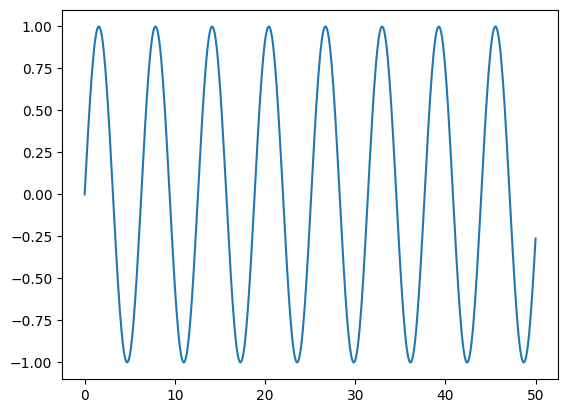

In [3]:
# Plot Data
plt.plot(x, y)

plt.show()

In [4]:
# Create a Pandas DataFrame
data = pd.DataFrame(data=y, index=x, columns=['Sin'])

In [5]:
data.head()

,Sin
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


# Data Preparation

## Train & Test Split

In [6]:
# Define test percentage of training data
test_percentage = 0.1

In [7]:
# Compute number of test samples
test_size = np.round(len(data)*test_percentage)

In [8]:
# Retrieve test set starting index
test_index = int(len(data) - test_size)

In [9]:
# Split between train and test
train_data = data.iloc[:test_index]
test_data = data.iloc[test_index:]

## Data Standardization

In [10]:
# Scale the data with MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

## Batch Generator

In [11]:
# Define number of time steps in the input and the batch size
input_steps = 4
batch_size = 1

In [12]:
# Define the batch generator
batch_generator = TimeseriesGenerator(train_data_scaled,
                                      train_data_scaled,
                                      length=input_steps,
                                      batch_size=batch_size)

In [13]:
# Retrieve one batch example
x, y = batch_generator[0]

print(f'x: {x}')
print(f'y: {y}')

x: [[[0.49999912]
  [0.54991622]
  [0.59933458]
  [0.64776041]]]
y: [[0.69470985]]


In [14]:
# Create the real batch generator with more input time steps
input_steps = 25
batch_size = 1

batch_generator = TimeseriesGenerator(train_data_scaled,
                                      train_data_scaled,
                                      length=input_steps,
                                      batch_size=batch_size)

# Modeling

## RNN

### Architecture

In [15]:
# Define the model
model = Sequential([
    # Number of neurons is equals to input time steps (25)
    SimpleRNN(units=input_steps, 
              input_shape=(input_steps, 1)), # 1 is the number of input features
    Dense(1) # We want to predict a single number
    
])

### Model Compile

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 25)                675       
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [18]:
# Fit through the batch_generator
model.fit(batch_generator, epochs=5)

Epoch 1/5


2023-07-05 22:36:46.656472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - 2s 3ms/step - loss: 0.0186
Epoch 2/5
426/426 [==============================] - 1s 3ms/step - loss: 1.7150e-04
Epoch 3/5
426/426 [==============================] - 1s 3ms/step - loss: 9.6328e-05
Epoch 4/5
426/426 [==============================] - 1s 3ms/step - loss: 1.3925e-04
Epoch 5/5
426/426 [==============================] - 1s 3ms/step - loss: 1.2777e-04


### Model Evaluation

#### Loss

In [19]:
# Retrieve loss
loss = pd.DataFrame(model.history.history)

<Axes: >

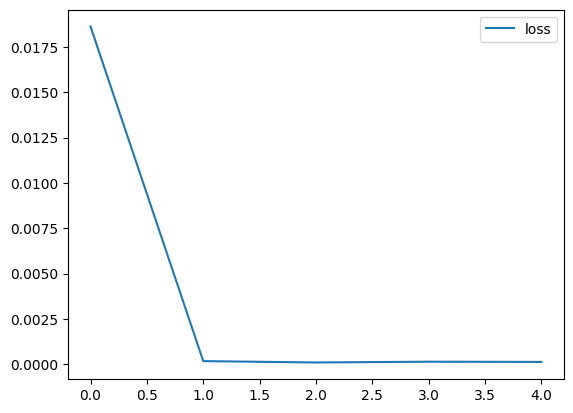

In [20]:
# Plot loss
loss.plot()

#### Plot Residuals

In [21]:
# Take the last training sequence and reshape it as the model expects (1, 25, 1)
first_evaluation_batch = train_data_scaled[-input_steps:].reshape((1, input_steps, 1))

In [22]:
# Get prediction for first evaluation batch
model.predict(first_evaluation_batch)

1/1 [==============================] - 0s 149ms/step


array([[0.94725466]], dtype=float32)

In [23]:
# Let's compare it with the first evaluation time step
print(test_data_scaled[0])

[0.94955134]


Pretty close to the actual prediction.

<br>

For making the prediciton over all the test set, we need to pass the current batch minus the first element and appending the new prediction each time, so that it keeps rolling forward.

In [24]:
# Initialise the prediciton for the test set
test_predictions = []

# Set the first evaluation batch
current_batch = first_evaluation_batch

# Loop though all the test set
for index in range(len(test_data_scaled)):

    # Predict
    prediction = model.predict(current_batch)[0]

    # Append the current prediction
    test_predictions.append(prediction)

    # Rolling forward
    current_batch = np.append(current_batch[:,1:,:],
                              [[prediction]], 
                              axis=1)

1/1 [==============================] - 0s 30ms/step


In [25]:
# Transform back the test predictions
test_unscaled_predictions = scaler.inverse_transform(test_predictions)

/var/folders/2t/wgg9ryl91kxd7b51f7g035jsdh30gy/T/ipykernel_9381/2261229699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predictions'] = test_unscaled_predictions


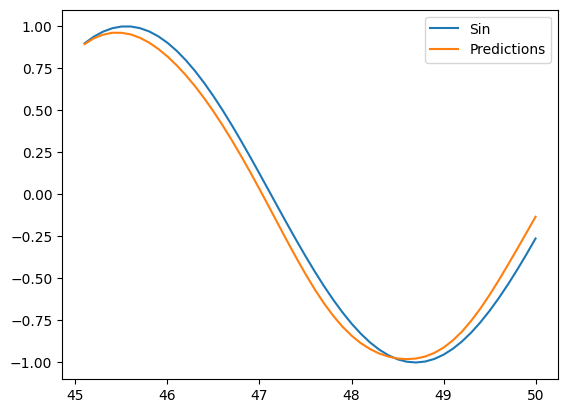

In [26]:
# Plot predictions vs true sequence
test_data['Predictions'] = test_unscaled_predictions

test_data.plot()

plt.show()

As you can see, predictions are getting more and more wrong as we move forward. That's because the new forecast is based on previous predictions as inputs.

## LSTM

### Architecture

In [27]:
# Define early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=2)

In [28]:
# Create a validation generator for the Early Stopping
validation_batch_generator = TimeseriesGenerator(test_data_scaled, 
                                                 test_data_scaled, 
                                                 length=input_steps, 
                                                 batch_size=1)

In [29]:
# Define the model
model = Sequential([
    # Number of neurons is equals to input time steps (25)
    LSTM(units=input_steps, 
              input_shape=(input_steps, 1)), # 1 is the number of input features
    Dense(1) # We want to predict a single number
    
])

2023-07-05 22:36:57.779309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 22:36:57.782052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 22:36:57.784680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### Model Compile

In [30]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

### Model Training

In [31]:
# Fit through the batch_generator
model.fit(batch_generator, 
          epochs=20, 
          validation_data=validation_batch_generator, 
          callbacks=[early_stopping_callback])

Epoch 1/20


2023-07-05 22:36:57.908606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-05 22:36:58.186661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 22:36:58.189091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

419/426 [============================>.] - ETA: 0s - loss: 0.0256

2023-07-05 22:37:02.246277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - 5s 7ms/step - loss: 0.0252 - val_loss: 5.1940e-05
Epoch 2/20


2023-07-05 22:37:02.539150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 22:37:02.540878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 22:37:02.542392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

426/426 [==============================] - 3s 7ms/step - loss: 1.5495e-04 - val_loss: 2.8088e-05
Epoch 3/20
426/426 [==============================] - 3s 7ms/step - loss: 1.7024e-04 - val_loss: 2.6488e-05
Epoch 4/20
426/426 [==============================] - 3s 6ms/step - loss: 1.6147e-04 - val_loss: 4.2331e-05
Epoch 5/20
426/426 [==============================] - 3s 8ms/step - loss: 1.0168e-04 - val_loss: 8.4139e-05


### Model Evaluation

#### Loss

In [32]:
# Retrieve loss
loss = pd.DataFrame(model.history.history)

<Axes: >

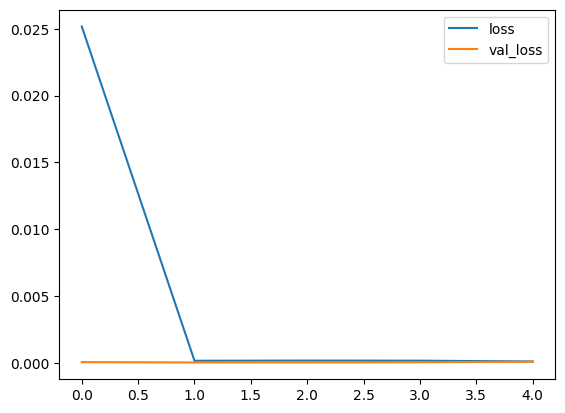

In [33]:
# Plot loss
loss.plot()

#### Plot Residuals

In [34]:
# Initialise the prediciton for the test set
test_predictions = []

# Set the first evaluation batch
current_batch = train_data_scaled[-input_steps:].reshape((1, input_steps, 1))

# Loop though all the test set
for index in range(len(test_data_scaled)):

    # Predict
    prediction = model.predict(current_batch)[0]

    # Append the current prediction
    test_predictions.append(prediction)

    # Rolling forward
    current_batch = np.append(current_batch[:,1:,:],
                              [[prediction]], 
                              axis=1)

1/1 [==============================] - ETA: 0s

2023-07-05 22:37:15.097643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 22:37:15.102667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 22:37:15.105290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 17ms/step


In [35]:
# Transform back the test predictions
test_unscaled_predictions = scaler.inverse_transform(test_predictions)

/var/folders/2t/wgg9ryl91kxd7b51f7g035jsdh30gy/T/ipykernel_9381/733346377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['LSTM Predictions'] = test_unscaled_predictions


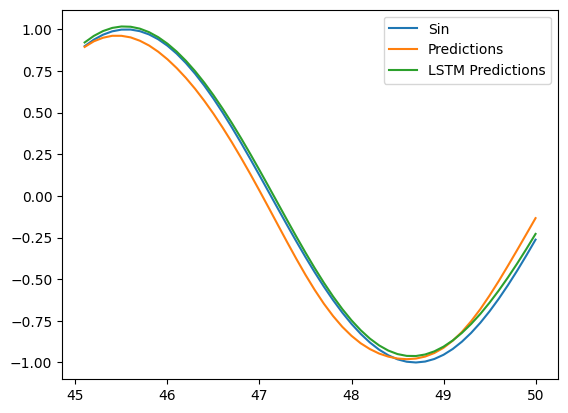

In [36]:
# Plot predictions vs true sequence
test_data['LSTM Predictions'] = test_unscaled_predictions

test_data.plot()

plt.show()